# sms ham & spam classification

## 1st we know how countvectorizer work


In [411]:
!pip install scikit-learn
!pip install pandas
!pip install seaborn
!pip install matplotlib

**now we are going to use transform function after fitiong the data**

**It will convert vocabulary to number(sparse matrix)**

**Now we are going to convert sparse matrix to a dense matrix**

# Now be going to work on original data 

In [412]:
#reading data
import warnings as wr
import pandas as pd
wr.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns

sms=pd.read_csv("./spam.csv", encoding='latin-1')
sms.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives around here though",NaN,NaN,NaN


In [413]:
sms.shape

(5572, 5)

<Axes: >

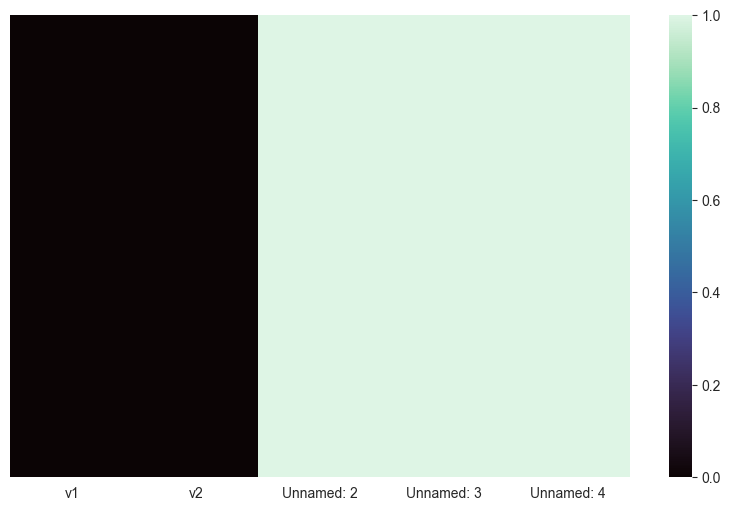

In [414]:
plt.figure(figsize=(10,6))
sns.heatmap(sms.isnull(),yticklabels=False,cbar=True,cmap='mako')

In [415]:
sms.isnull().sum()

v1               0
v2               0
Unnamed: 2    5522
Unnamed: 3    5560
Unnamed: 4    5566
dtype: int64

Here we can say there are many NaN value in unnamed columns, so we are going to drop those frature

In [416]:
sms=sms.drop(["Unnamed: 2","Unnamed: 3","Unnamed: 4"],axis=1)
sms.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives around here though"


Feature description
* v1=label(ham/spam) outcome to predict
* v2=sms

In [417]:
sms.v1.value_counts()

v1
ham     4825
spam     747
Name: count, dtype: int64

<Axes: xlabel='v1', ylabel='count'>

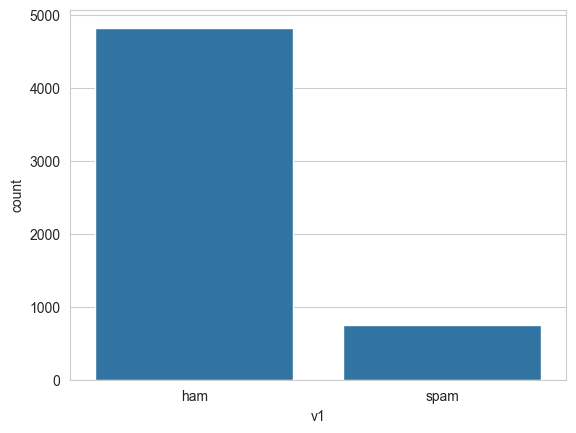

In [418]:
sns.countplot(x="v1", data = sms)

In [419]:
# convert label to a numerical variable
sms['v1'] = sms.v1.map({'ham':0, 'spam':1})

In [420]:
sms.head()

,v1,v2
0,0,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives around here though"


**Balance Data**

In [421]:
ham=sms[sms["v1"]==0]
spam=sms[sms["v1"]==1]

In [422]:
ham.shape,spam.shape

((4825, 2), (747, 2))

In [423]:
# ham=ham.sample(spam.shape[0])
ham.shape

(4825, 2)

In [424]:
data = pd.concat([ham, spam], ignore_index=True)
print("Shape :", data.shape)
data.head()

Shape : (5572, 2)


,v1,v2
0,0,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat..."
1,0,Ok lar... Joking wif u oni...
2,0,U dun say so early hor... U c already then say...
3,0,"Nah I don't think he goes to usf, he lives around here though"
4,0,Even my brother is not like to speak with me. They treat me like aids patent.


<Axes: xlabel='v1', ylabel='count'>

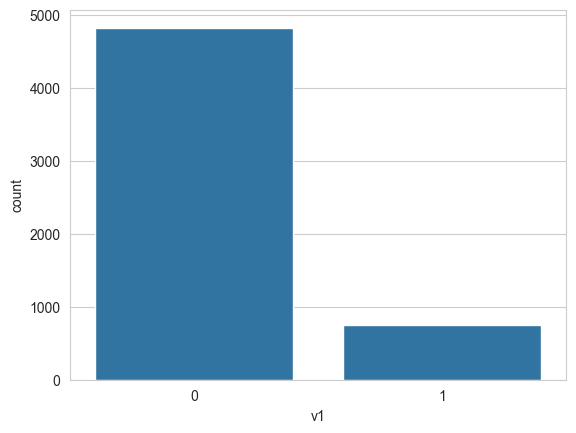

In [425]:
sns.countplot(x="v1", data=data)

* Now we can see data is balanced

**dividing data in X & Y**

In [426]:
X = data.v2
y = data.v1

# Model building

In [427]:
# split X and y into training and testing sets
# by default, it splits 75% training and 25% test
# random_state=1 for reproducibility

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=5)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(4179,)
(1393,)
(4179,)
(1393,)


In [428]:
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer()

In [429]:
X_train_dtm = vect.fit_transform(X_train)

In [430]:
X_train_dtm

<4179x7395 sparse matrix of type '<class 'numpy.int64'>'
	with 55109 stored elements in Compressed Sparse Row format>

In [431]:
# 4. transform testing data (using fitted vocabulary) into a document-term matrix
X_test_dtm = vect.transform(X_test)
X_test_dtm

# you can see that the number of columns, 7456, is the same as what we have learned above in X_train_dtm

<1393x7395 sparse matrix of type '<class 'numpy.int64'>'
	with 17413 stored elements in Compressed Sparse Row format>

# MultinomialNB
**MultinomialNB is the one of the best algo for Text data**

In [432]:
# 1. import
from sklearn.naive_bayes import MultinomialNB

# 2. instantiate a Multinomial Naive Bayes model
nb = MultinomialNB()

In [433]:
# 3. train the model 

nb.fit(X_train_dtm, y_train)

MultinomialNB()

In [434]:
# 4. make class predictions for X_test_dtm
y_pred_class = nb.predict(X_test_dtm)

In [435]:
# calculate accuracy of class predictions
from sklearn import metrics
metrics.accuracy_score(y_test, y_pred_class)

0.9827709978463748

**Here we got .98 score**

**printing the confusion matrix**
to compare actual and prediction

In [436]:

cf_matrix=metrics.confusion_matrix(y_test, y_pred_class)
cf_matrix

array([[1201,    3],
       [  21,  168]])

<Axes: >

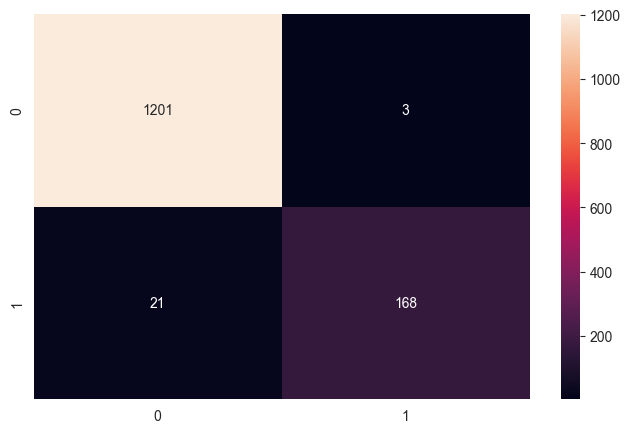

In [437]:
import matplotlib.pyplot as plt
#Ploting confusion matrix
plt.figure(figsize=(8,5))
sns.heatmap(cf_matrix, annot=True, fmt='d')

In [438]:
# print message text for the false positives (ham incorrectly classified as spam)

X_test[(y_pred_class==1) & (y_test==0)]

4208                    Nokia phone is lovly..
3784    Mathews or tait or edwards or anderson
4066                    I liked the new mobile
Name: v2, dtype: object

In [439]:
# print message text for the false negatives (spam incorrectly classified as ham)
X_test[(y_pred_class==0) & (y_test==1)]

5204                                           How come it takes so little time for a child who is afraid of the dark to become a teenager who wants to stay out all night?
5495                              You can donate å£2.50 to UNICEF's Asian Tsunami disaster support fund by texting DONATE to 864233. å£2.50 will be added to your next bill
5176              Your next amazing xxx PICSFREE1 video will be sent to you enjoy! If one vid is not enough for 2day text back the keyword PICSFREE1 to get the next video.
5284      Am new 2 club & dont fink we met yet Will B gr8 2 C U Please leave msg 2day wiv ur area 09099726553 reply promised CARLIE x Callså£1/minMobsmore LKPOBOX177HP51FL
5057                                                                            0A$NETWORKS allow companies to bill for SMS, so they are responsible for their \suppliers\"
5472                                                                                                  Check Out Choose Your Babe Videos @ sm

In [440]:
# calculate AUC
y_pred_prob = nb.predict_proba(X_test_dtm)[:, 1]
metrics.roc_auc_score(y_test, y_pred_prob)

0.977807660531913

# LogisticRegression

In [441]:
# 1. import
from sklearn.linear_model import LogisticRegression

# 2. instantiate a logistic regression model
logreg = LogisticRegression()

In [442]:
# 3. train the model using X_train_dtm
logreg.fit(X_train_dtm, y_train)

LogisticRegression()

In [443]:
# 4. make class predictions for X_test_dtm
y_pred_class = logreg.predict(X_test_dtm)

In [444]:
# calculate predicted probabilities for X_test_dtm (well calibrated)
y_pred_prob = logreg.predict_proba(X_test_dtm)[:, 1]
y_pred_prob

array([3.54268931e-03, 8.70159741e-01, 3.76196686e-03, ...,
       2.22365287e-05, 1.21252789e-01, 9.99962411e-01])

In [445]:
# calculate accuracy
metrics.accuracy_score(y_test, y_pred_class)

0.9763101220387652

In [446]:
# calculate AUC
metrics.roc_auc_score(y_test, y_pred_prob)

0.9909077326020848

In [447]:
# remove English stop words
vect1 = CountVectorizer(stop_words='english')

X_train_1 = vect1.fit_transform(X_train)

X_train_1


<4179x7136 sparse matrix of type '<class 'numpy.int64'>'
	with 32373 stored elements in Compressed Sparse Row format>

In [448]:
# include 1-grams and 2-grams

# how to differentiate between "Happy", "Not Happy", "Very Happy"
vect2 = CountVectorizer(ngram_range=(1, 2))

X_train_2 = vect2.fit_transform(X_train)

X_train_2

<4179x40734 sparse matrix of type '<class 'numpy.int64'>'
	with 110149 stored elements in Compressed Sparse Row format>

In [449]:
# ignore terms that appear in more than 50% of the documents
vect3 = CountVectorizer(max_df=0.5)

X_train_3 = vect3.fit_transform(X_train)

X_train_3

<4179x7395 sparse matrix of type '<class 'numpy.int64'>'
	with 55109 stored elements in Compressed Sparse Row format>

In [450]:
# only keep terms that appear in at least 2 documents
vect4 = CountVectorizer(min_df=2)

X_train_4 = vect4.fit_transform(X_train)

X_train_4

<4179x3451 sparse matrix of type '<class 'numpy.int64'>'
	with 51165 stored elements in Compressed Sparse Row format>

In [451]:
vect_combined= CountVectorizer(stop_words='english',ngram_range=(1, 2),min_df=2,max_df=0.5)

In [452]:
X_train_c = vect_combined.fit_transform(X_train)
X_test_c = vect_combined.transform(X_test)

X_train_c

<4179x6818 sparse matrix of type '<class 'numpy.int64'>'
	with 39029 stored elements in Compressed Sparse Row format>

In [453]:
# 1. import
from sklearn.naive_bayes import MultinomialNB

# 2. instantiate a Multinomial Naive Bayes model
nb = MultinomialNB()

nb.fit(X_train_c, y_train)

y_pred_class = nb.predict(X_test_c)

nb_cf_matrix=metrics.confusion_matrix(y_test, y_pred_class)

<Axes: >

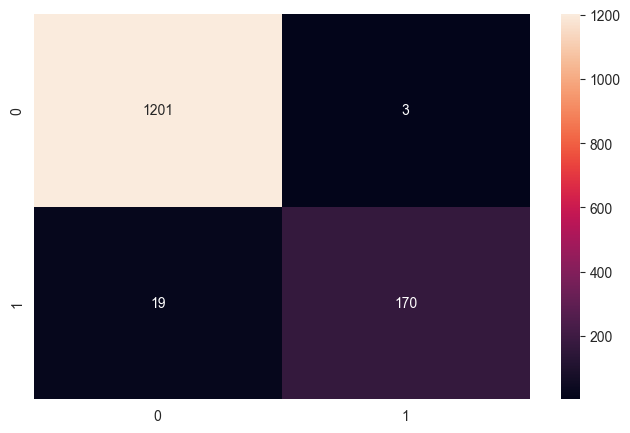

In [454]:
plt.figure(figsize=(8,5))
sns.heatmap(nb_cf_matrix, annot=True, fmt='d')

In [ ]:
!pip install gradio
import gradio as gr

def classify_message(message):
    user_input_dtm = vect_combined.transform([message])  # Vectorize the input message
    prediction = nb.predict(user_input_dtm)  # Predict using the trained model
    return 'Spam' if prediction[0] == 1 else 'Ham'
# Create the Gradio interface
interface = gr.Interface(
    fn=classify_message,
    inputs=gr.Textbox(lines=2, placeholder="Enter SMS message..."),
    outputs=gr.Textbox(),
    title="SMS Ham/Spam Classifier",
    description="Enter an SMS message to classify it as Ham or Spam."
)

# Launch the interface
interface.launch(debug='True')

Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.
